<a href="https://colab.research.google.com/github/fikrifaizz/Brain-Tumor-MRI-Classification/blob/main/notebooks/03_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

np.random.seed(42)
tf.random.set_seed(42)

TensorFlow: 2.20.0
GPU: []


In [54]:
# Paths
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')
RESULTS_DIR = Path('../results')

MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)
(RESULTS_DIR / 'comparison').mkdir(exist_ok=True)

# Data
BATCH_SIZE = 32
CLASSES = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
NUM_CLASSES = 4

# Training
STAGE1_EPOCHS = 10
STAGE2_EPOCHS = 15
STAGE1_LR = 1e-3
STAGE2_LR = 1e-5

print(f"Batch size: {BATCH_SIZE}")
print(f"Classes: {CLASSES}")

Batch size: 32
Classes: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


In [51]:
# Augmentation layer - apply ONLY to training data
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name='augmentation')

print("Augmentation layer created")

Augmentation layer created


In [53]:
# ResNet50 uses 224x224 images
train_ds_resnet = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'train',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

val_ds_resnet = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'val',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds_resnet = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'test',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Apply augmentation + ResNet preprocessing
train_ds_resnet = train_ds_resnet.map(
    lambda x, y: (augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda x, y: (resnet_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_ds_resnet = val_ds_resnet.map(
    lambda x, y: (resnet_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds_resnet = test_ds_resnet.map(
    lambda x, y: (resnet_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print("ResNet50 data (224x224) loaded")

Found 5617 files belonging to 4 classes.
Found 702 files belonging to 4 classes.
Found 704 files belonging to 4 classes.
ResNet50 data (224x224) loaded


In [55]:
# InceptionV3 prefers 299x299 images
train_ds_inception = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'train',
    image_size=(299, 299),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

val_ds_inception = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'val',
    image_size=(299, 299),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds_inception = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'test',
    image_size=(299, 299),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Apply augmentation + Inception preprocessing
train_ds_inception = train_ds_inception.map(
    lambda x, y: (augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda x, y: (inception_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_ds_inception = val_ds_inception.map(
    lambda x, y: (inception_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds_inception = test_ds_inception.map(
    lambda x, y: (inception_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print("InceptionV3 data (299x299) loaded")

Found 5617 files belonging to 4 classes.
Found 702 files belonging to 4 classes.
Found 704 files belonging to 4 classes.
InceptionV3 data (299x299) loaded


In [56]:
# InceptionV3 prefers 299x299 images
train_ds_densenet = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'train',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

val_ds_densenet = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'val',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds_densenet = keras.utils.image_dataset_from_directory(
    DATA_DIR / 'test',
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Apply augmentation + DenseNet preprocessing
train_ds_densenet = train_ds_densenet.map(
    lambda x, y: (augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda x, y: (densenet_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_ds_densenet = val_ds_densenet.map(
    lambda x, y: (densenet_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds_densenet = test_ds_densenet.map(
    lambda x, y: (densenet_preprocess(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print("DenseNet121 data (224x224) loaded")

Found 5617 files belonging to 4 classes.
Found 702 files belonging to 4 classes.
Found 704 files belonging to 4 classes.
DenseNet121 data (224x224) loaded


In [57]:
# Get training labels
train_labels = []
for _, labels in train_ds_resnet.unbatch():
    train_labels.append(np.argmax(labels.numpy()))

train_labels = np.array(train_labels)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for i, cls in enumerate(CLASSES):
    count = (train_labels == i).sum()
    print(f"  {cls:12s}: {count:4d} samples, weight={class_weights[i]:.3f}")

Class weights:
  Glioma      : 1296 samples, weight=1.084
  Meningioma  : 1316 samples, weight=1.067
  No Tumor    : 1600 samples, weight=0.878
  Pituitary   : 1405 samples, weight=0.999


2025-11-14 11:14:50.223881: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [58]:
def train_two_stage(model, base_model, model_name, train_ds, val_ds):
    
    # Stage 1: Frozen backbone
    print("\nSTAGE 1: Training classifier only")
    model.compile(
        optimizer=keras.optimizers.Adam(STAGE1_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history_s1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=STAGE1_EPOCHS,
        class_weight=class_weight_dict,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
            keras.callbacks.ModelCheckpoint(
                MODEL_DIR / f'{model_name}_stage1.keras',
                save_best_only=True
            )
        ],
        verbose=1
    )
    
    # Stage 2: Fine-tune
    print("\nSTAGE 2: Fine-tuning top layers")
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model.compile(
        optimizer=keras.optimizers.Adam(STAGE2_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history_s2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=STAGE2_EPOCHS,
        initial_epoch=len(history_s1.history['loss']),
        class_weight=class_weight_dict,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
            keras.callbacks.ModelCheckpoint(
                MODEL_DIR / f'{model_name}_stage2.keras',
                save_best_only=True
            )
        ],
        verbose=1
    )
    
    print(f"\n{model_name} training complete")
    return history_s1, history_s2

print("Helper function defined")

Helper function defined


In [59]:
# Build ResNet50
base_resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_resnet.trainable = False

inputs_resnet = keras.Input(shape=(224, 224, 3))
x = base_resnet(inputs_resnet, training=False)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs_resnet = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet = keras.Model(inputs_resnet, outputs_resnet, name='resnet50')

print(f"ResNet50 params: {model_resnet.count_params():,}")

ResNet50 params: 24,113,284


In [60]:
# Train ResNet50
hist_resnet_s1, hist_resnet_s2 = train_two_stage(
    model_resnet, 
    base_resnet, 
    'resnet50',
    train_ds_resnet, 
    val_ds_resnet
)


STAGE 1: Training classifier only
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 111s 619ms/step - accuracy: 0.7842 - loss: 2.3666 - val_accuracy: 0.8433 - val_loss: 1.1393 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 617ms/step - accuracy: 0.8562 - loss: 0.9093 - val_accuracy: 0.8689 - val_loss: 0.7174 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 119s 672ms/step - accuracy: 0.8640 - loss: 0.6852 - val_accuracy: 0.8447 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 114s 644ms/step - accuracy: 0.8547 - loss: 0.6251 - val_accuracy: 0.8932 - val_loss: 0.5157 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 115s 647ms/step - accuracy: 0.8707 - loss: 0.5487 - val_accuracy: 0.8547 - val_loss: 0.5241 - learning_rate: 0.0010
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 110s 621ms/step - accuracy: 0.8661 - loss: 0.5427 - val_accuracy: 0.9017 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 7/10
176/176 ━━━━━━━━━━

In [62]:
# Build InceptionV3
base_inception = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3),
    pooling='avg'
)
base_inception.trainable = False

inputs_inception = keras.Input(shape=(299, 299, 3))
x = base_inception(inputs_inception, training=False)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs_inception = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_inception = keras.Model(inputs_inception, outputs_inception, name='inceptionv3')

print(f"InceptionV3 params: {model_inception.count_params():,}")

InceptionV3 params: 22,065,572


In [63]:
# Train InceptionV3
hist_inception_s1, hist_inception_s2 = train_two_stage(
    model_inception,
    base_inception,
    'inceptionv3',
    train_ds_inception,
    val_ds_inception
)


STAGE 1: Training classifier only
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 168s 939ms/step - accuracy: 0.7575 - loss: 1.6890 - val_accuracy: 0.8034 - val_loss: 0.9527 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 164s 927ms/step - accuracy: 0.8254 - loss: 0.8181 - val_accuracy: 0.8291 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 166s 936ms/step - accuracy: 0.8296 - loss: 0.6880 - val_accuracy: 0.7977 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 174s 982ms/step - accuracy: 0.8318 - loss: 0.6354 - val_accuracy: 0.8732 - val_loss: 0.5434 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8302 - loss: 0.6219 - val_accuracy: 0.8433 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 172s 973ms/step - accuracy: 0.8364 - loss: 0.5891 - val_accuracy: 0.8362 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 7/10
176/176 ━━━━━━━━━━━━━

In [67]:
# Build DenseNet121
base_densenet = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_densenet.trainable = False

inputs_densenet = keras.Input(shape=(224, 224, 3))
x = base_densenet(inputs_densenet, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs_densenet = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_densenet = keras.Model(inputs_densenet, outputs_densenet, name='densenet121')

print(f"DenseNet121 params: {model_densenet.count_params():,}")

DenseNet121 params: 7,169,220


In [68]:
# Train DenseNet121
hist_densenet_s1, hist_densenet_s2 = train_two_stage(
    model_densenet,
    base_densenet,
    'densenet121',
    train_ds_densenet,
    val_ds_densenet
)


STAGE 1: Training classifier only
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 597ms/step - accuracy: 0.7365 - loss: 1.5971 - val_accuracy: 0.8689 - val_loss: 0.8754 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 596ms/step - accuracy: 0.8172 - loss: 0.8752 - val_accuracy: 0.8661 - val_loss: 0.6690 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 585ms/step - accuracy: 0.8332 - loss: 0.7160 - val_accuracy: 0.8348 - val_loss: 0.6265 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 596ms/step - accuracy: 0.8389 - loss: 0.6246 - val_accuracy: 0.8405 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 108s 610ms/step - accuracy: 0.8442 - loss: 0.5859 - val_accuracy: 0.8860 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 606ms/step - accuracy: 0.8432 - loss: 0.5662 - val_accuracy: 0.8305 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 7/10
176/176 ━━━━━━━━━━

In [69]:
# Load best models
best_resnet = keras.models.load_model(MODEL_DIR / 'resnet50_stage2.keras')
best_inception = keras.models.load_model(MODEL_DIR / 'inceptionv3_stage2.keras')
best_densenet = keras.models.load_model(MODEL_DIR / 'densenet121_stage2.keras')

# Evaluate
print("MODEL EVALUATION")

# ResNet50
loss_resnet, acc_resnet = best_resnet.evaluate(test_ds_resnet, verbose=0)
print(f"\nResNet50:")
print(f"  Test Loss:     {loss_resnet:.4f}")
print(f"  Test Accuracy: {acc_resnet:.4f} ({acc_resnet*100:.2f}%)")

# InceptionV3
loss_inception, acc_inception = best_inception.evaluate(test_ds_inception, verbose=0)
print(f"\nInceptionV3:")
print(f"  Test Loss:     {loss_inception:.4f}")
print(f"  Test Accuracy: {acc_inception:.4f} ({acc_inception*100:.2f}%)")

loss_densenet, acc_densenet = best_densenet.evaluate(test_ds_densenet, verbose=0)
print(f"\nDenseNet121:")
print(f"  Test Loss:     {loss_densenet:.4f}")
print(f"  Test Accuracy: {acc_densenet:.4f} ({acc_densenet*100:.2f}%)")

# Winner
if acc_resnet >= acc_inception and acc_resnet >= acc_densenet:
    winner = "ResNet50"
elif acc_inception >= acc_resnet and acc_inception >= acc_densenet:
    winner = "InceptionV3"
else:
    winner = "DenseNet121"
print(f"\nBest Model: {winner}")

MODEL EVALUATION

ResNet50:
  Test Loss:     0.2357
  Test Accuracy: 0.9673 (96.73%)

InceptionV3:
  Test Loss:     0.3800
  Test Accuracy: 0.9062 (90.62%)

DenseNet121:
  Test Loss:     0.3766
  Test Accuracy: 0.9077 (90.77%)

Best Model: ResNet50


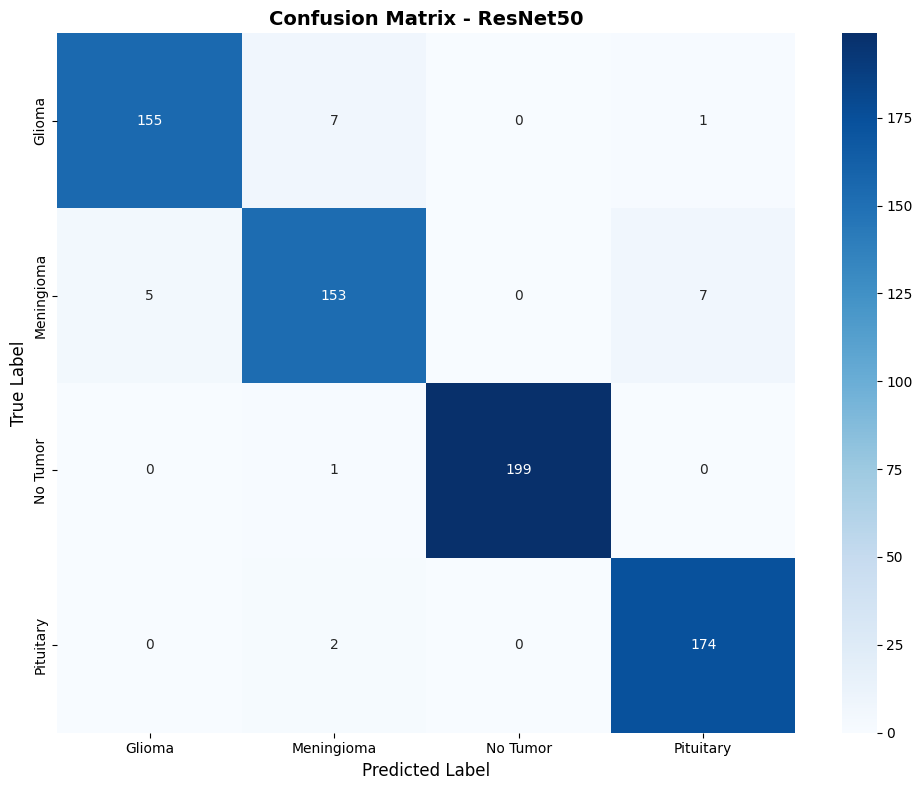


ResNet50 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.97      0.95      0.96       163
  Meningioma       0.94      0.93      0.93       165
    No Tumor       1.00      0.99      1.00       200
   Pituitary       0.96      0.99      0.97       176

    accuracy                           0.97       704
   macro avg       0.97      0.97      0.97       704
weighted avg       0.97      0.97      0.97       704



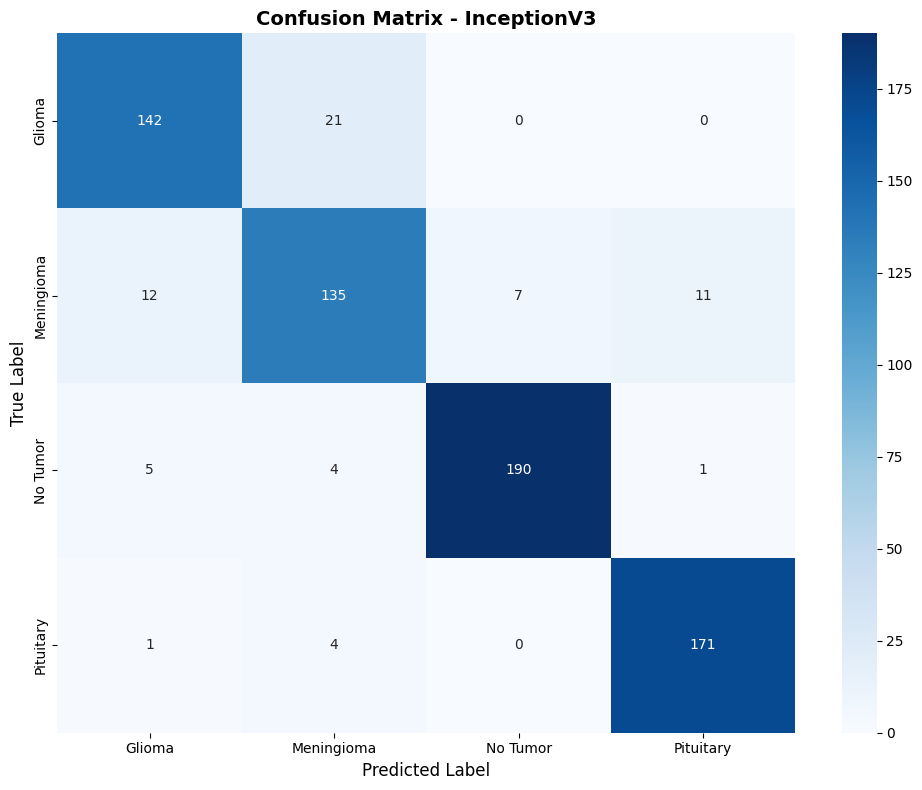


InceptionV3 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.89      0.87      0.88       163
  Meningioma       0.82      0.82      0.82       165
    No Tumor       0.96      0.95      0.96       200
   Pituitary       0.93      0.97      0.95       176

    accuracy                           0.91       704
   macro avg       0.90      0.90      0.90       704
weighted avg       0.91      0.91      0.91       704



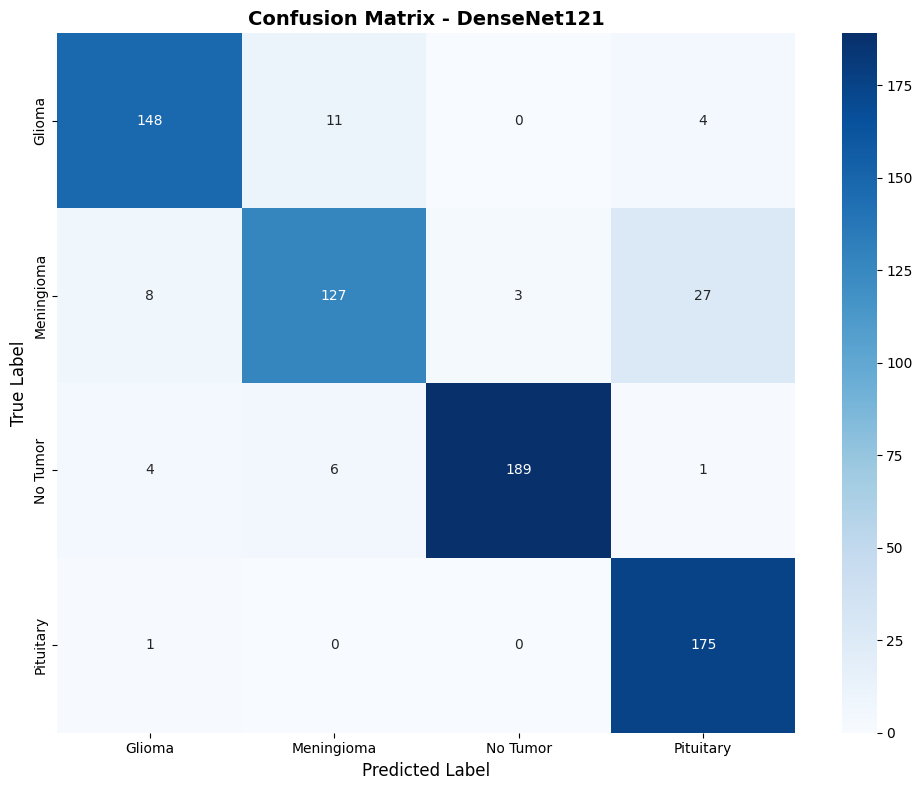


DenseNet121 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.92      0.91      0.91       163
  Meningioma       0.88      0.77      0.82       165
    No Tumor       0.98      0.94      0.96       200
   Pituitary       0.85      0.99      0.91       176

    accuracy                           0.91       704
   macro avg       0.91      0.90      0.90       704
weighted avg       0.91      0.91      0.91       704



In [70]:
def plot_confusion_matrix(model, test_ds, model_name):
    # Predictions
    y_pred = model.predict(test_ds, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # True labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true_classes = np.argmax(y_true, axis=1)
    
    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'cm_{model_name.lower()}.png', dpi=150)
    plt.show()
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES))
    
    return cm

# Plot both
cm_resnet = plot_confusion_matrix(best_resnet, test_ds_resnet, 'ResNet50')
cm_inception = plot_confusion_matrix(best_inception, test_ds_inception, 'InceptionV3')
cm_densenet = plot_confusion_matrix(best_densenet, test_ds_densenet, 'DenseNet121')

MODEL COMPARISON
      Model Parameters Input Size Test Accuracy Test Loss
   ResNet50 24,113,284    224×224        0.9673    0.2357
InceptionV3 22,065,572    299×299        0.9062    0.3800
DenseNet121  7,169,220    224×224        0.9077    0.3766


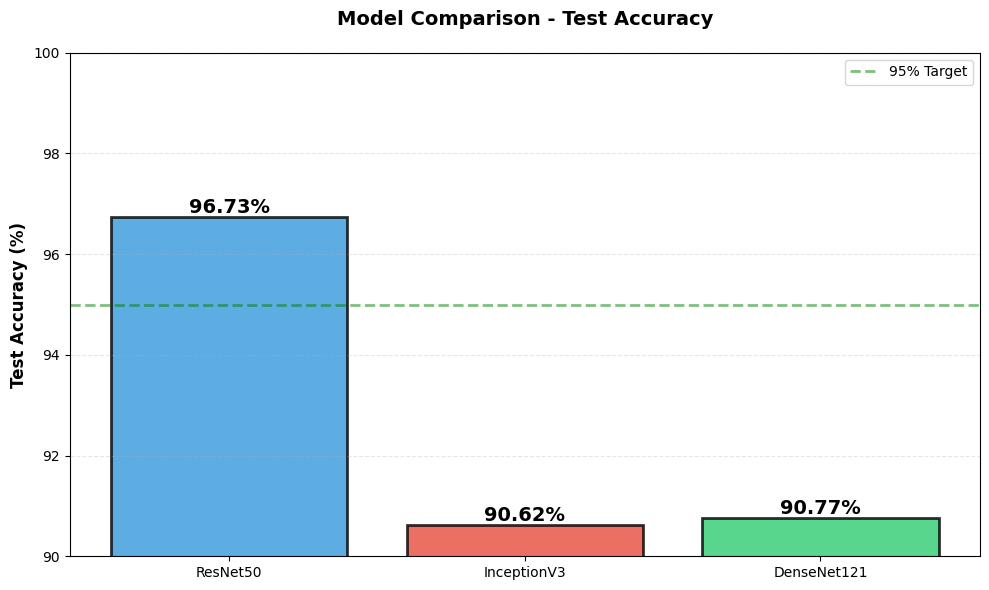


 Results saved to ../results


In [72]:
# Comparison table
comparison = pd.DataFrame([
    {
        'Model': 'ResNet50',
        'Parameters': f"{model_resnet.count_params():,}",
        'Input Size': '224×224',
        'Test Accuracy': f"{acc_resnet:.4f}",
        'Test Loss': f"{loss_resnet:.4f}"
    },
    {
        'Model': 'InceptionV3',
        'Parameters': f"{model_inception.count_params():,}",
        'Input Size': '299×299',
        'Test Accuracy': f"{acc_inception:.4f}",
        'Test Loss': f"{loss_inception:.4f}"
    },
    {
        'Model': 'DenseNet121',
        'Parameters': f"{model_densenet.count_params():,}",
        'Input Size': '224×224',
        'Test Accuracy': f"{acc_densenet:.4f}",
        'Test Loss': f"{loss_densenet:.4f}"
    }
])

print("MODEL COMPARISON")
print(comparison.to_string(index=False))

# Save
comparison.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['ResNet50', 'InceptionV3', 'DenseNet121']
accuracies = [acc_resnet * 100, acc_inception * 100, acc_densenet * 100]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([90, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=95, color='green', linestyle='--', linewidth=2, alpha=0.5, label='95% Target')
ax.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparison' / 'accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Results saved to {RESULTS_DIR}")